In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pprint
pp = pprint.PrettyPrinter().pprint

import sys

In [3]:
from satbazaar import db
from satbazaar import schedulers
from satbazaar import client

In [4]:
# script 'get-stations.py' creates this file
stations = db.load_stations('data/stations.json')

# script 'get-satellites.py' creates both files
satellites = db.load_satellites('data/satellites.json', 'data/tle.sqlite')

In [5]:
gs = stations['KB9JHU']

# script 'generate-allpasses.py' generates the database of sat-gs pass predictions
passes = db.getpasses(dbfile='data/passes.sqlite', gs=gs['name'], start='2018-07-11', end='2018-07-11 04:00')

In [6]:
c = client.AllClient(gs)
clients = schedulers.random_scheduler(passes=passes, clients={gs['name']:c}, satellites=satellites, debug=True)

print(c)
print('c.calendar_value():')
for currency, amount in c.calendar_value().items():
    print('%11s: %f' % (currency, amount))
print('c.busy_time():', c.busy_time())

****************************************************************************************************************************************************************
AllClient (KB9JHU lat=39.24, lon=-86.31, alt=280.00)
c.calendar_value():
        SNC: 60185.240966
c.busy_time(): 60185.240966


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [8]:
# collect satellite names
sats = set([p.data['job']['tle0'] for p in c.calendar])
sats = list(sats)
sats.sort()
sats.reverse()
#index is used as y-offset


# sats simultaneously overhead
from datetime import datetime, timedelta
from iso8601 import parse_date
start = c.calendar.begin()  #parse_date('2018-07-11')
end = c.calendar.end()  #parse_date('2018-07-11 04:00')

total_minutes = (end - start).total_seconds()/60
steps = [start + timedelta(minutes=x) for x in range(int(total_minutes))]
num = []
for t in steps:
    passes = c.calendar[t]
    num.append(len(passes))


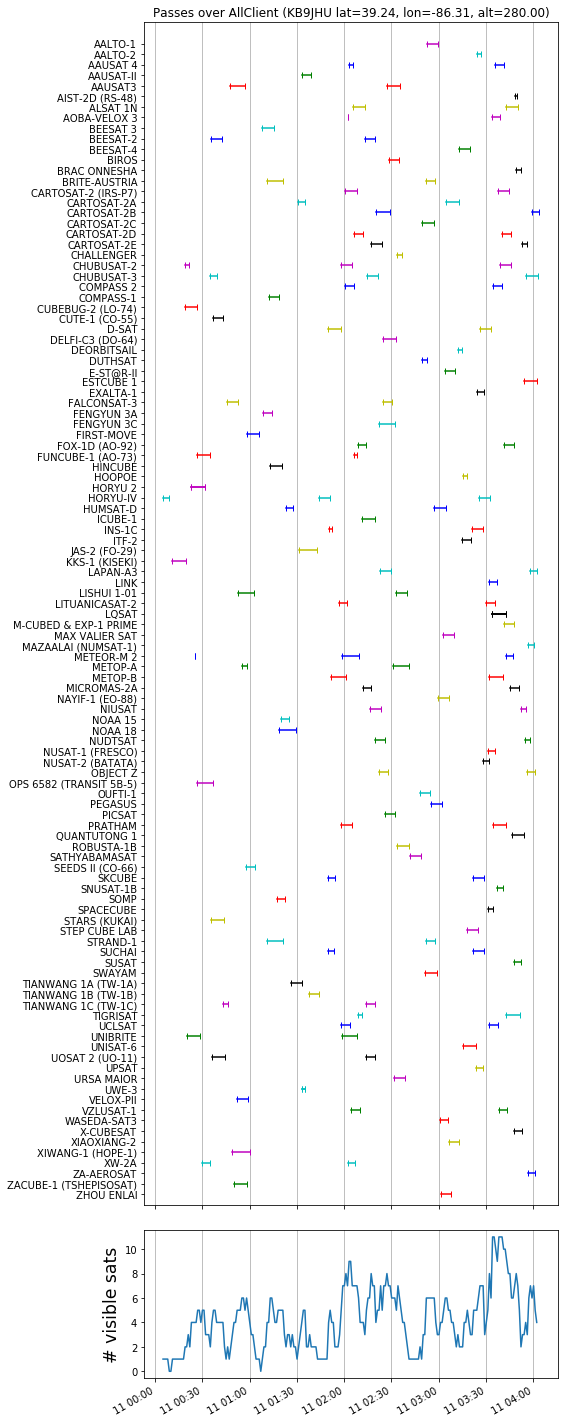

In [9]:
plt.close('all')
fig = plt.figure(figsize=(8, 24))

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[8, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

ax0.xaxis_date()
ax0.set_ylim(-1, len(sats)+1)

from itertools import cycle, islice
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

for p in c.calendar:
    sat = p.data['job']['tle0']
    idx = sats.index(sat)
    ax0.plot((p.begin, p.end),
             2*[idx],
             '-|',
             color=colors[idx%len(colors)])

ax0.set_yticks(range(len(sats)))
ax0.set_yticklabels(sats)
ax0.set_title('Passes over %s' % c)
ax0.grid(True, axis='x')


# lower plot
ax1.plot(steps, num)
ax1.xaxis_date()
ax1.grid(True, axis='x')
ax1.set_ylabel('# visible sats', fontsize='xx-large')

plt.tight_layout()
fig.autofmt_xdate()

#plt.savefig('kb9jhu.png', dpi=150, bbox_inches='tight')

In [10]:
np.mean(num)

4.214285714285714